Time Series Forecasting (Research Lab,2023)

Rossmann Store Sales Forecast 

Rossmann operates over 3,000 drugstores in 7 European countries. Currently, Rossmann store managers have to forecast their daily sales up to six weeks in advance. Store sales are influenced by many factors, such as promotions, competition, school and public holidays, seasonal and local conditions. Because thousands of store managers forecast sales based on their individual circumstances, the accuracy of results can vary widely. This booklet focuses primarily on time series analysis (seasonal decomposition, trends, autocorrelation).

Steps to be performed

1.Data pre-processing and cleaning                                                                                               
2.Visualize the data                                                                                                             
3.Make the time series data stationary, if required                                                                             
4.Plot correlation and auto-correlation charts                                                                                   
5.Selection of the parameters and building of model for the plotting                                                             
6.Use the model to make the required predictions 

In [1]:
#!pip install xgboost
#!pip install pmdarima

In [28]:
#!pip install fbprophet

In [1]:
from prophet import Prophet

In [1]:
#pip install tensorflow


In [1]:
# importing all the required libraries

#for data manipulation and calculations
import numpy as np
import pandas as pd
from datetime import datetime
from time import time

#for data plotting and visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
#matplotlib inline
import itertools
from scipy import stats

#for time series analysis
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# prophet by Facebook
#from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

#lstmmodel
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import layers

Dataset

I have taken the dataset of Rossman Stores sales data from the Kaggle website. The dataset included 3 csv files, store.csv, train.csv and test.csv.
Using the train.csv and test.csv, the model can be trained to perform the required predictions. 
Additional store.csv is given to work upon the feature selection and to check whether the data is stationary or not.

Link for the dataset - https://www.kaggle.com/competitions/rossmann-store-sales/data

In [2]:
#importing training dataset

train = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/train.csv")
test = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/test.csv")
store = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/store.csv")

In [3]:
#train = train.set_index('Date')

In [4]:
train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

In [5]:
#train.info()

In [6]:
#checking the train data
#train.head().append(train.tail())

In [7]:
#checking the test data
#test.head().append(test.tail())

In [8]:
#checking the store data
#store.head().append(store.tail())
#store.describe()

EXPLORATORY DATA ANALYSIS (EDA) on the given dataset:

To perform data cleaning, data pre-processing, checking the sales trend that vary with different factors.

In [9]:
display(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
display(test.isnull().sum())

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [11]:
display(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
#display(test[pd.isnull(test.Open)])

In [3]:
# replacing the null values with 1
test.fillna(1, inplace=True)

In [4]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [15]:
#display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

In [5]:
# for working with the Sarima Model

train1 = train
train2 = pd.merge(train1, store, on='Store')   

# for working with the Xgboost model

df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

In [6]:
#combining the two features to create a new feature that describes average sales per customer

train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2.shape

(1017209, 19)

In [7]:
def features_create(data):
    
    data['Date'] = pd.to_datetime(data['Date'])

    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [8]:
features_create(df_train_store)
features_create(df_test_store)
#features_create(train2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,1,3,2015-09-17,1.0,1,0,0,3,1,...,0.0,,2015,9,17,38,84.0,24189.50,Sept,0
1,857,1,2,2015-09-16,1.0,1,0,0,3,1,...,0.0,,2015,9,16,38,84.0,24189.50,Sept,0
2,1713,1,1,2015-09-15,1.0,1,0,0,3,1,...,0.0,,2015,9,15,38,84.0,24189.50,Sept,0
3,2569,1,0,2015-09-14,1.0,1,0,0,3,1,...,0.0,,2015,9,14,38,84.0,24189.50,Sept,0
4,3425,1,6,2015-09-13,0.0,0,0,0,3,1,...,0.0,,2015,9,13,37,84.0,24189.25,Sept,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,2,2015-08-05,1.0,1,0,1,4,3,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,5,32,24188.0,38.50,Aug,0
41084,38520,1115,1,2015-08-04,1.0,1,0,1,4,3,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,4,32,24188.0,38.50,Aug,0
41085,39376,1115,0,2015-08-03,1.0,1,0,1,4,3,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,3,32,24188.0,38.50,Aug,0
41086,40232,1115,6,2015-08-02,0.0,0,0,1,4,3,...,2012.0,"Mar,Jun,Sept,Dec",2015,8,2,31,24188.0,38.25,Aug,0


In [105]:
#plotting the trends of sales, customers and sales/cutomer to check whether these trends are affected by the store type and the promotional events.

#sns.factorplot(data = train2, x = 'Month', y = "Sales", 
#col = 'StoreType', #for different store types
#hue = 'StoreType',
#row = 'Promo', #for different promos
#) 

<AxesSubplot:>

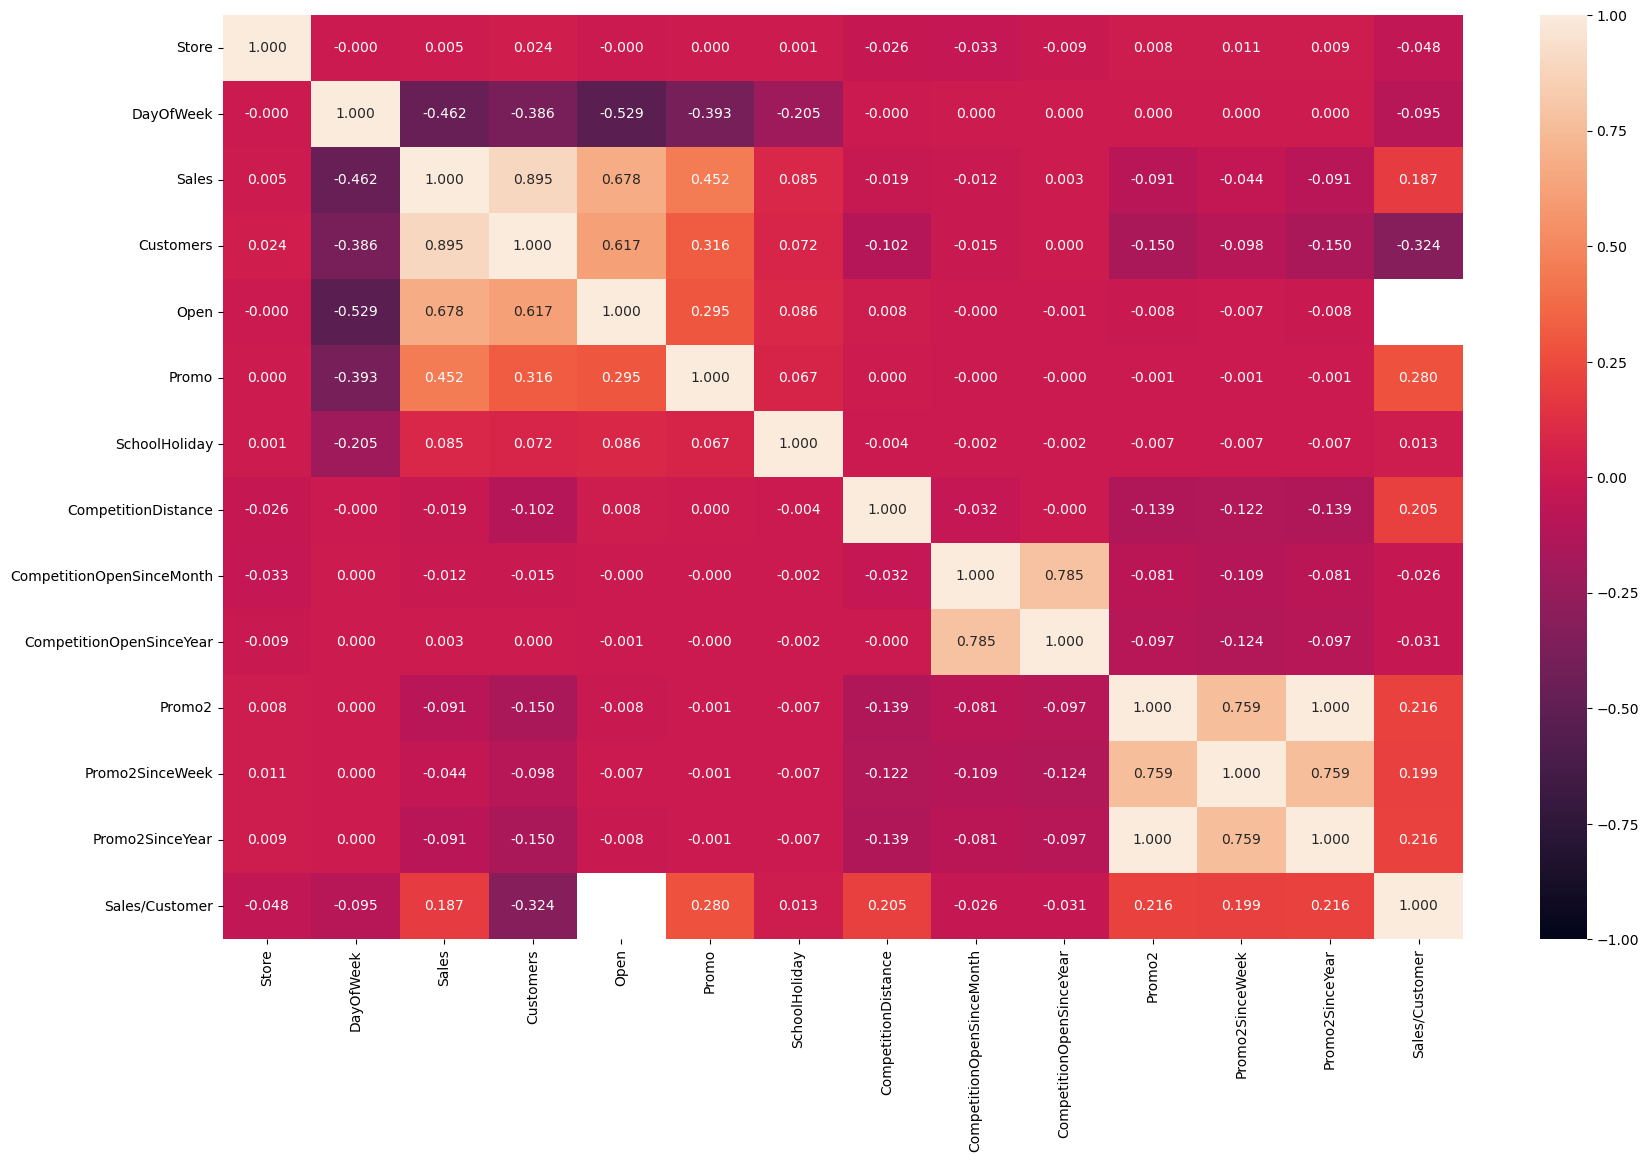

In [9]:
plt.figure(figsize = (20,12))

sns.heatmap(train2.corr(),annot = True, fmt = '.3f',vmin = -1,vmax = 1)

In [10]:
train2 = train2.set_index('Date')

In [19]:
#train2

In [11]:
train2['Sales'] = train2['Sales'] * 1.0

sales_a = pd.DataFrame()
sales_a['Sales'] = train2[train2.Store == 2]['Sales']
#sales_b = train2[train2.Store == 85]['Sales']
#sales_c = train2[train2.Store == 1]['Sales']
#sales_d = train2[train2.Store == 13]['Sales']

# sales_a.describe()
sales_a.head()

,Sales
Date,
2015-07-31,6064.0
2015-07-30,5567.0
2015-07-29,6402.0
2015-07-28,5671.0
2015-07-27,6627.0


In [12]:
sales_a['Sales']

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
               ...  
2013-01-05    2342.0
2013-01-04    4484.0
2013-01-03    4159.0
2013-01-02    4422.0
2013-01-01       0.0
Name: Sales, Length: 942, dtype: float64

In [29]:
# Extract the sales values as the target variable
sales_data = sales_a['Sales'].values.reshape(-1, 1)
#sales_data

In [28]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
sales_data = scaler.fit_transform(sales_data)
#sales_data

In [15]:
# Split data into training (70%) and test (30%)
train_size = int(0.7 * len(sales_data))
train = sales_data[:train_size]
#test = sales_data[train_size:]

In [16]:
        x_train = []
        y_train = []

        for i in range(60, len(train)):
            x_train.append(train[i-60:i, 0])
            y_train.append(train[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        print(x_train.shape)

        test = sales_data[train_size-60:, :]
        x_test = []
        y_test = sales_data[train_size:]

        for i in range(60, len(test)):
            x_test.append(test[i-60:i, 0])

        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        print(sales_data.shape,x_train.shape,y_train.shape,x_test.shape,y_test.shape)


(599, 60, 1)
(942, 1) (599, 60, 1) (599,) (283, 60, 1) (283, 1)


In [17]:
# Build an LSTM model
model = keras.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(layers.LSTM(50, return_sequences=False))
model.add(layers.Dense(15))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 15)                765       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 31381 (122.58 KB)
Trainable params: 31381 (122.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=64,verbose = 2)

Epoch 1/10
10/10 - 6s - loss: 0.0769 - 6s/epoch - 588ms/step
Epoch 2/10
10/10 - 1s - loss: 0.0628 - 613ms/epoch - 61ms/step
Epoch 3/10
10/10 - 1s - loss: 0.0563 - 623ms/epoch - 62ms/step
Epoch 4/10
10/10 - 1s - loss: 0.0551 - 639ms/epoch - 64ms/step
Epoch 5/10
10/10 - 1s - loss: 0.0546 - 623ms/epoch - 62ms/step
Epoch 6/10
10/10 - 1s - loss: 0.0539 - 637ms/epoch - 64ms/step
Epoch 7/10
10/10 - 1s - loss: 0.0538 - 630ms/epoch - 63ms/step
Epoch 8/10
10/10 - 1s - loss: 0.0535 - 621ms/epoch - 62ms/step
Epoch 9/10
10/10 - 1s - loss: 0.0527 - 616ms/epoch - 62ms/step
Epoch 10/10
10/10 - 1s - loss: 0.0530 - 619ms/epoch - 62ms/step


In [19]:
predictions = model.predict(x_test)

9/9 [==============================] - 1s 21ms/step


In [20]:
predictions.shape,y_test.shape

((283, 1), (283, 1))

In [25]:
#predictions, y_test

In [26]:
prediction1 = predictions
y_pred = scaler.inverse_transform(prediction1)
#y_pred.shape,y_pred

In [27]:
y_test_1 = y_test
y_test_1 = scaler.inverse_transform(y_test_1.reshape(-1, 1))
#y_test_1.shape,y_test_1

In [24]:
 rmse = np.sqrt(np.mean(y_pred - y_test_1) ** 2)
 rmse

157.7961348139355

In [37]:
predictions_list = y_pred.tolist()
Actual = y_test_1.tolist()
df = pd.DataFrame({'Predictions': predictions_list, 'Actual': Actual})
print(df)

             Predictions    Actual
0     [3911.14990234375]  [4972.0]
1    [3908.041748046875]  [7006.0]
2      [3915.8388671875]  [6282.0]
3     [3927.39111328125]  [7368.0]
4     [3950.64013671875]     [0.0]
..                   ...       ...
278   [3898.94677734375]  [2342.0]
279   [3907.64990234375]  [4484.0]
280    [3924.9306640625]  [4159.0]
281      [3940.16015625]  [4422.0]
282  [3953.526611328125]     [0.0]

[283 rows x 2 columns]
